# Transformer Theory and Implementations

In [1]:
import tensorflow as tf
tf.__version__

'2.4.0'

## Data Preprocessing

In [4]:
import tensorflow as tf
import numpy as np
import unicodedata
import re

raw_data = (
    ('What a ridiculous concept!', 'Quel concept ridicule !'),
    ('Your idea is not entirely crazy.', "Votre idée n'est pas complètement folle."),
    ("A man's worth lies in what he is.", "La valeur d'un homme réside dans ce qu'il est."),
    ('What he did is very wrong.', "Ce qu'il a fait est très mal."),
    ("All three of you need to do that.", "Vous avez besoin de faire cela, tous les trois."),
    ("Are you giving me another chance?", "Me donnez-vous une autre chance ?"),
    ("Both Tom and Mary work as models.", "Tom et Mary travaillent tous les deux comme mannequins."),
    ("Can I have a few minutes, please?", "Puis-je avoir quelques minutes, je vous prie ?"),
    ("Could you close the door, please?", "Pourriez-vous fermer la porte, s'il vous plaît ?"),
    ("Did you plant pumpkins this year?", "Cette année, avez-vous planté des citrouilles ?"),
    ("Do you ever study in the library?", "Est-ce que vous étudiez à la bibliothèque des fois ?"),
    ("Don't be deceived by appearances.", "Ne vous laissez pas abuser par les apparences."),
    ("Excuse me. Can you speak English?", "Je vous prie de m'excuser ! Savez-vous parler anglais ?"),
    ("Few people know the true meaning.", "Peu de gens savent ce que cela veut réellement dire."),
    ("Germany produced many scientists.", "L'Allemagne a produit beaucoup de scientifiques."),
    ("Guess whose birthday it is today.", "Devine de qui c'est l'anniversaire, aujourd'hui !"),
    ("He acted like he owned the place.", "Il s'est comporté comme s'il possédait l'endroit."),
    ("Honesty will pay in the long run.", "L'honnêteté paye à la longue."),
    ("How do we know this isn't a trap?", "Comment savez-vous qu'il ne s'agit pas d'un piège ?"),
    ("I can't believe you're giving up.", "Je n'arrive pas à croire que vous abandonniez."),
)

In [5]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def normalize_string(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s

In [7]:
raw_data_en, raw_data_fr = list(zip(*raw_data))
raw_data_en, raw_data_fr = list(raw_data_en), list(raw_data_fr)

raw_data_en = [normalize_string(data) for data in raw_data_en]
raw_data_fr_in = ['<start> ' + normalize_string(data) for data in raw_data_fr]
raw_data_fr_out = [normalize_string(data) + ' <end>' for data in raw_data_fr]

In [9]:
en_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
en_tokenizer.fit_on_texts(raw_data_en)
data_en = en_tokenizer.texts_to_sequences(raw_data_en)

data_en = tf.keras.preprocessing.sequence.pad_sequences(data_en,
                                                        padding='post')

In [11]:
fr_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

fr_tokenizer.fit_on_texts(raw_data_fr_in)
fr_tokenizer.fit_on_texts(raw_data_fr_out)

data_fr_in = fr_tokenizer.texts_to_sequences(raw_data_fr_in)
data_fr_in = tf.keras.preprocessing.sequence.pad_sequences(data_fr_in,
                                                           padding='post')

data_fr_out = fr_tokenizer.texts_to_sequences(raw_data_fr_out)
data_fr_out = tf.keras.preprocessing.sequence.pad_sequences(data_fr_out,
                                                            padding='post')

In [12]:
dataset = tf.data.Dataset.from_tensor_slices(
    (data_en, data_fr_in, data_fr_out))
dataset = dataset.shuffle(20).batch(5)

## Encoder Components
- Embedding
- Positional Encoding
- Multi-Head Attention
- Position wise FFN


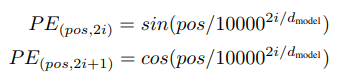

In [3]:
def positional_embedding(pos,model_size):
  PE = np.zeros((1,model_size))

  for i in range(model_size):
    if i%2 == 0:
      PE[:,i] = np.sin(pos/10000**(i/model_size))
    else:
      PE[:,i] = np.cos(pos/10000**((i-1)/model_size))

  return PE


In [13]:
max_length = max(len(data_en[0]),len(data_fr_in[0]))
MODEL_SIZE = 128

pes = []

for i in range(max_length):
  pes.append(positional_embedding(i,MODEL_SIZE))

pes = np.concatenate(pes,axis =0)
pes = tf.constant(pes,dtype=tf.float32)

### Multihead Attention
- Source sequence pays attention to itself (Encoder’s self attention)
- Target sequence pays attention to itself (Decoder’s self attention)
- Target sequence pays attention to source sequence (same as Seq2Seq)


- Query: the one which pays attention
- (Key, Value): the one to which attention is drawn. Key and value are exactly the same within this post.

In [17]:
class MultiHeadAttention(tf.keras.Model):
  def __init__(self,model_size,h):
    # h = head size
    super(MultiHeadAttention,self).__init__()
    self.query_size = model_size//h
    self.key_size = model_size//h
    self.value_size = model_size//h
    self.h = h
    self.wq = [tf.keras.layers.Dense(self.query_size) for _ in range(h)]
    self.wk = [tf.keras.layers.Dense(self.key_size) for _ in range(h)]
    self.wv = [tf.keras.layers.Dense(self.value_size) for _ in range(h)]
    self.wo = tf.keras.layers.Dense(model_size)
  def call(self,query,value):

    # shapes (batch,query_len,model_size)
    heads = []
    for i in range(self.h):
      score = tf.matmul(self.wq[i](query),self.wk[i](value),transpose_b = True)/tf.math.sqrt(tf.dtypes.cast(self.key_size,tf.float32))
      alignment = tf.nn.softmax(score,axis =2)
      head = tf.matmul(alignment,self.wv[i](value))
      heads.append(head)
    heads = tf.concat(heads, axis=2)
    heads = self.wo(heads)
    return heads



### Encoder Blocks
- One Embedding layer
- One or many layers, each layer contains:
  - One Multi-Head Attention block
  - One Normalization layer for Attention block
  - One Feed-Forward Network block
  - One Normalization layer for FFN block

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self,vocab_size,model_size,num_layers,h):
    super(Encoder,self).__init__()
    self.model_size = model_size
    self.num_layers = num_layers
    self.h = h

    self.embedding = tf.keras.Layers.Embedding(vocab_size,model_size)
    self.attention = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
    self.attention_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]

        # num_layers FFN and Normalization layers
    self.dense_1 = [tf.keras.layers.Dense(model_size * 4, activation='relu') for _ in range(num_layers)]
    self.dense_2 = [tf.keras.layers.Dense(model_size) for _ in range(num_layers)]
    self.ffn_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]

  def call(self, sequence):
        sub_in = []
        for i in range(sequence.shape[1]):
            # Compute the embedded vector
            embed = self.embedding(tf.expand_dims(sequence[:, i], axis=1))
            
            # Add positional encoding to the embedded vector
            sub_in.append(embed + pes[i, :])
        
        # Concatenate the result so that the shape is (batch_size, length, model_size)
        sub_in = tf.concat(sub_in, axis=1)
        
        # We will have num_layers of (Attention + FFN)
        for i in range(self.num_layers):
            sub_out = []

            # Iterate along the sequence length
            for j in range(sub_in.shape[1]):
                # Compute the context vector towards the whole sequence
                attention = self.attention[i](
                    tf.expand_dims(sub_in[:, j, :], axis=1), sub_in)

                sub_out.append(attention)

            # Concatenate the result to have shape (batch_size, length, model_size)
            sub_out = tf.concat(sub_out, axis=1)

            # Residual connection
            sub_out = sub_in + sub_out
            # Normalize the output
            sub_out = self.attention_norm[i](sub_out)

            # The FFN input is the output of the Multi-Head Attention
            ffn_in = sub_out

            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            # Add the residual connection
            ffn_out = ffn_in + ffn_out
            # Normalize the output
            ffn_out = self.ffn_norm[i](ffn_out)

            # Assign the FFN output to the next layer's Multi-Head Attention input
            sub_in = ffn_out
            
        # Return the result when done
        return ffn_out

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, model_size, num_layers, h):
        super(Decoder, self).__init__()
        self.model_size = model_size
        self.num_layers = num_layers
        self.h = h
        self.embedding = tf.keras.layers.Embedding(vocab_size, model_size)
        self.attention_bot = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_bot_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        self.attention_mid = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_mid_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        self.dense_1 = [tf.keras.layers.Dense(model_size * 4, activation='relu') for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(model_size) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        self.dense = tf.keras.layers.Dense(vocab_size)
    def call(self, sequence, encoder_output):
        # EMBEDDING AND POSITIONAL EMBEDDING
        embed_out = []
        for i in range(sequence.shape[1]):
            embed = self.embedding(tf.expand_dims(sequence[:, i], axis=1))
            embed_out.append(embed + pes[i, :])
            
        embed_out = tf.concat(embed_out, axis=1)
        
        
        bot_sub_in = embed_out
        
        for i in range(self.num_layers):
            # BOTTOM MULTIHEAD SUB LAYER
            bot_sub_out = []
            
            for j in range(bot_sub_in.shape[1]):
                values = bot_sub_in[:, :j, :]
                attention = self.attention_bot[i](
                    tf.expand_dims(bot_sub_in[:, j, :], axis=1), values)

                bot_sub_out.append(attention)
            bot_sub_out = tf.concat(bot_sub_out, axis=1)
            bot_sub_out = bot_sub_in + bot_sub_out
            bot_sub_out = self.attention_bot_norm[i](bot_sub_out)
            
            # MIDDLE MULTIHEAD SUB LAYER
            mid_sub_in = bot_sub_out

            mid_sub_out = []
            for j in range(mid_sub_in.shape[1]):
                attention = self.attention_mid[i](
                    tf.expand_dims(mid_sub_in[:, j, :], axis=1), encoder_output)

                mid_sub_out.append(attention)

            mid_sub_out = tf.concat(mid_sub_out, axis=1)
            mid_sub_out = mid_sub_out + mid_sub_in
            mid_sub_out = self.attention_mid_norm[i](mid_sub_out)

            # FFN
            ffn_in = mid_sub_out

            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            ffn_out = ffn_out + ffn_in
            ffn_out = self.ffn_norm[i](ffn_out)

            bot_sub_in = ffn_out
        
        logits = self.dense(ffn_out)
            
        return logits

In [ ]:
H = 2
NUM_LAYERS = 2

en_vocab_size = len(en_tokenizer.word_index) + 1
encoder = Encoder(en_vocab_size, MODEL_SIZE, NUM_LAYERS, H)

en_sequence_in = tf.constant([[1, 2, 3, 4, 6, 7, 8, 0, 0, 0], 
                           [1, 2, 3, 4, 6, 7, 8, 0, 0, 0]])
encoder_output = encoder(en_sequence_in)

print('Input vocabulary size', en_vocab_size)
print('Encoder input shape', en_sequence_in.shape)
print('Encoder output shape', encoder_output.shape)

fr_vocab_size = len(fr_tokenizer.word_index) + 1
max_len_fr = data_fr_in.shape[1]
decoder = Decoder(fr_vocab_size, MODEL_SIZE, NUM_LAYERS, H)

fr_sequence_in = tf.constant([[1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 0],
                           [1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 0]])
decoder_output = decoder(fr_sequence_in, encoder_output)

print('Target vocabulary size', fr_vocab_size)
print('Decoder input shape', fr_sequence_in.shape)
print('Decoder output shape', decoder_output.shape)

In [ ]:
BATCH_SIZE = 5
dataset = tf.data.Dataset.from_tensor_slices(
    (data_en, data_fr_in, data_fr_out))
dataset = dataset.shuffle(20).batch(BATCH_SIZE)

In [ ]:
crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)


def loss_func(targets, logits):
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss


optimizer = tf.keras.optimizers.Adam()

In [ ]:
@tf.function
def train_step(source_seq, target_seq_in, target_seq_out):
    with tf.GradientTape() as tape:
        encoder_output = encoder(source_seq)
        
        decoder_output = decoder(target_seq_in, encoder_output)

        loss = loss_func(target_seq_out, decoder_output)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

In [ ]:
def predict(test_source_text=None):
    # If test sentence is not provided
    # randomly pick up one from the training data
    if test_source_text is None:
        test_source_text = raw_data_en[np.random.choice(len(raw_data_en))]

    print(test_source_text)
    
    # Tokenize the test sentence to obtain source sequence
    test_source_seq = en_tokenizer.texts_to_sequences([test_source_text])
    print(test_source_seq)

    en_output = encoder(tf.constant(test_source_seq))

    de_input = tf.constant([[fr_tokenizer.word_index['<start>']]], dtype=tf.int64)

    out_words = []

    while True:
        de_output = decoder(de_input, en_output)
        
        # Take the last token as the predicted token
        new_word = tf.expand_dims(tf.argmax(de_output, -1)[:, -1], axis=1)
        out_words.append(fr_tokenizer.index_word[new_word.numpy()[0][0]])

        # The next input is a new sequence
        # contains both the input sequence and the predicted token
        de_input = tf.concat((de_input, new_word), axis=-1)

        # End if hitting <end> or length exceeds 14
        if out_words[-1] == '<end>' or len(out_words) >= 14:
            break

    print(' '.join(out_words))

In [ ]:
NUM_EPOCHS = 100

start_time = time.time()
for e in range(NUM_EPOCHS):
    for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
        loss = train_step(source_seq, target_seq_in,
                          target_seq_out)

    print('Epoch {} Loss {:.4f}'.format(
          e + 1, loss.numpy()))

    if (e + 1) % 10 == 0:
        end_time = time.time()
        print('Average elapsed time: {:.2f}s'.format((end_time - start_time) / (e + 1)))
        try:
            predict()
        except Exception as e:
            print(e)
            continue